In [7]:
import pandas as pd
import numpy as np

data_train = pd.read_csv('./p4/train_data.csv').iloc[:, 1:] #leave out the idx
data_test = pd.read_csv('./p4/test_data.csv').iloc[:, 1:]

x_train = data_train.iloc[:, :-1]
x_test = data_test.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
y_test = data_test.iloc[:, -1]

In [8]:
# Normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_std = np.mat(scaler.fit_transform(x_train))
x_test_std = np.mat(scaler.fit_transform(x_test))

# One-hot Coding

y_train_dummy = np.mat(pd.get_dummies(y_train))
y_test_dummy = np.mat(pd.get_dummies(y_test))

In [9]:
y_train_dummy[1]

matrix([[0, 0, 1, 0]], dtype=uint8)

In [10]:
K = len(pd.value_counts(y_train))
K

4

In [11]:
import math
import numpy as np
from functools import reduce

def Softmax(x, y, theta_):
    '''
    x: (1,d) / (n, d)
    theta: (K, d)
    y: (1,K) / (n, K) in one-hot coding

    output: 
    res: (1,1) / (n, 1)
    '''
    res = np.where(y, np.exp(x.dot(theta_.T)), y) 
    # One-hot coding as the indicator, leaves out where it is 0 in l of x*theta.T
    # np.where would return a copy in ndarray
    return res.sum(axis=1, keepdims=1) / np.exp(x.dot(theta_.T)).sum(axis=1)


def loss(x, y, theta_):
    '''returns a scalar in float'''
    return - np.log(Softmax(x, y, theta_)).sum() / len(x)


def grad(x, y, theta_):
    '''return (K, d)'''

    def grad_j(j):
        '''This function calculates the gradient for class j in (1, d)'''

        tmp1 = np.mat(np.where(y[:,j], x, y[:, j])).sum(axis=0) 
        # The first term in gradient, reduced to (1, d)
        padded_p = np.exp(x.dot(np.mat(theta_[j]).T)) / np.exp(x.dot(theta_.T)).sum(axis=1) + np.zeros((1,20)) 
        # Pad the probability Pr(j | X) to (n, d) to enable matrix multipliction
        # Pr(j | X) not Pr(y[j] | X), what is relavant in y[i] has been dealt with in tmp1
        tmp2 = np.prod([padded_p, x_train_std], axis=0).sum(axis=0) 
        # On the diagonal is the sum of probability*x_t; together the 2nd term, (1, d)

        return  tmp2 - tmp1

    def stack_v(a, b):
        return np.vstack((a, b))
    res = reduce(stack_v, [grad_j(j) for j in range(K)])

    return res / len(x)
        


In [12]:
alpha = 0.01

def AGD(ini_theta):   
    theta = ini_theta - alpha * grad(x_train_std, y_train_dummy, ini_theta) 
    theta_old = ini_theta

    train_loss = [loss(x_train_std, y_train_dummy, ini_theta)] # To record the training loss after each iteration
    test_loss = [loss(x_test_std, y_test_dummy, ini_theta)] # testing loss
    
    # print('iter:')

    for t in range(1, max_iter):
        train_loss.append(loss(x_train_std, y_train_dummy, theta))
        test_loss.append(loss(x_test_std, y_test_dummy, theta))

        theta_v = theta + (t-1)/(t+2) * (theta - theta_old)
        theta_new = theta_v - alpha * grad(x_train_std, y_train_dummy, theta_v)
        
        # print(t, end=' ')

        theta_old, theta = theta, theta_new
        
    train_loss.append(loss(x_train_std, y_train_dummy, theta_new))
    test_loss.append(loss(x_test_std, y_test_dummy, theta_new))

    return theta_new, train_loss, test_loss

In [13]:
max_iter = 2000 

a = np.random.random((K ,20))
theta_fin, train_loss, test_loss = AGD(a)

iter:


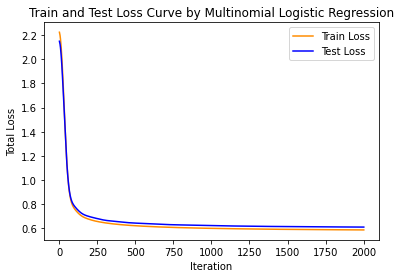

In [291]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, max_iter+2), train_loss, c='darkorange', label='Train Loss')
plt.plot(np.arange(1, max_iter+2), test_loss, c='blue', label='Test Loss')
plt.xlabel("Iteration")
plt.ylabel("Total Loss")
plt.title("Train and Test Loss Curve by Multinomial Logistic Regression")
plt.legend()
plt.show()

In [14]:
# Prediction
def predict(x):
    '''
    x: mat, (n, d)
    theta_fin: mat, (K, d), the learnt parameters

    output: 
    y_pred: array, (n,), whose elements all in range(0,4)
    '''
    y_pred = []
    for xi in x:
        l = np.diag(np.ones(4))
        res = list(np.array(Softmax(xi, l, theta_fin)).T[0])
        yi_pred = res.index(max(res))
        y_pred.append(yi_pred)
    return y_pred

y_train_pred = predict(x_train_std)
y_test_pred = predict(x_test_std)

In [15]:
# Accuracy
from sklearn.metrics import accuracy_score

print(f'The train accuracy: {accuracy_score(y_train, y_train_pred)}')
print(f'The test accuracy: {accuracy_score(y_test, y_test_pred)}')

The train accuracy: 0.6294117647058823
The test accuracy: 0.62
